# IMDB Image API

This notebook is intended to build an imdb class that sources images associated with a given move from IMDB. Images can then be used in downstream applications such as segmentation, classification, etc. 

This notebook will show how to establish the basic functionality of automating url requests, image downloads, etc., and will then build this functionality into a class that is easy to use and modular.

### The first thing we need to do is to explore IMDB, in order to figure out how to grab images. 

On the page for the 1982 movie Blade Runner, "https://www.imdb.com/title/tt0083658/", 
there is a link to associated photos: "https://www.imdb.com/title/tt0083658/mediaindex?page=1&ref_=ttmi_mi_sm"
Page 2 of the photos: "https://www.imdb.com/title/tt0083658/mediaindex?page=2&ref_=ttmi_mi_sm"

Note that the url for the photo pages is the base url, plus "mediaindex", plus an API request including a page number and some unknown search terms. Using this, we can automatically build out the image urls for a given movie entry, simply by interating through page numbers where the http request status code is valid (200). 



In [447]:
# import required libraries:

from PIL import Image
import requests
from io import BytesIO
import re
from bs4 import BeautifulSoup
import os
import io

## For a given movie entry, in this case Blade Runner (1982), find all urls of movie images:

In [71]:
# using string formatting, we can insert a page number into a base url:

base_url = "https://www.imdb.com/title/tt0083658/"
image_url = base_url + "?page={}&ref_=ttmi_mi_sm".format(1)
image_url

'https://www.imdb.com/title/tt0083658/?page=1&ref_=ttmi_mi_sm'

In [79]:
# check that this is a valid url, ie that an http request has a status code == 200:

test_url = requests.get(image_url)
test_url.status_code

200

In [107]:
# pull all href (ie link) tabs from a given record. These can then be filtered to collect only the image urls:

url = requests.get("https://www.imdb.com/title/tt0083658/mediaindex")
# Extracting the source code of the page:
data = url.text
 
# Create a beautiful soup object from the text:
soup = BeautifulSoup(data, 'lxml')
 
# Extract all the <a> tags into a list.
tags = soup.find_all('a')
 
# Extrac URLs from the href attribute in the <a> tags. Keep only unique records with an attached page number:
href_list = []
for tag in tags:
    if "page=" in str(tag.get('href')) and tag not in href_list:
        
        href_list.append("https://www.imdb.com" + tag.get('href'))
set(href_list)

{'https://www.imdb.com/title/tt0083658/mediaindex?page=2&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=3&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=4&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=5&ref_=ttmi_mi_sm'}

## Collect images from a given url:



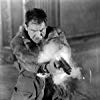

In [119]:
#use one of the urls collected above as a test url:

images_url = href_list[0]
response = requests.get(images_url)

#find all image tags using html.parser:
soup = BeautifulSoup(response.text, 'html.parser')
img_tags = soup.find_all('img')

#use list comprehension to build a list of jpg images:
images = [img['src'] for img in img_tags if img['src'][-3:] == "jpg"]

#use BytesIO to view an associated images from this list. Note that the first list item is the movie poster:
image_response = requests.get(images[1])
img = Image.open(BytesIO(image_response.content))
img

## Build a local list of these images:

In [120]:
jpg_list  =[]
for jpg in images:
    jpg_response = requests.get(jpg)
    jpg_list.append(Image.open(BytesIO(jpg_response.content)))

    

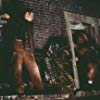

In [147]:
jpg_list[11]

In [232]:
#for a given base url, get the movie title:

#https://www.imdb.com/title/tt0083658/
base_url

url = requests.get(base_url)
# Extracting the source code of the page:
data = url.text
 
# Create a beautiful soup object from the text:
soup = BeautifulSoup(data, 'lxml')
 
# Extract all the <a> tags into a list.
tags = soup.find_all('h1')

    
for tag in tags:
    text = tag.text

url

<Response [200]>

# Now that the basic functionality is in hand, we can build it into a more useful set of functions:

In [545]:
#Build an imdb class that retrieves urls for images:

class imdb:
    
    
    
    def __init__(self, name):
        
        '''
        parse html to return the movie title and year associated with a given entry:
        '''
        base_url = "https://www.imdb.com/title/"
        self.name = name
        self.url = base_url + self.name + "/"
        
    def title(record):        
        url = requests.get(record.url)
        data = url.text
        soup = BeautifulSoup(data, 'lxml')
        tags = soup.find_all('h1')
        for tag in tags:
            text = tag.text
        return text.replace(u'\xa0', u' ')
    
    def image_index_urls(record):
        '''
        return list of urls with image files for a given record:
        '''    
        url = requests.get(record.url + "mediaindex")
        data = url.text 
        soup = BeautifulSoup(data, 'lxml')
        
        #find all 'a' tags with an href attribute, then append those tags
        tags = soup.find_all('a')
        href_list = [record.url + "mediaindex"]
        for tag in tags:
            if "page=" in str(tag.get('href')):       
                href_list.append("https://www.imdb.com" + tag.get('href'))
        return set(href_list)#.add(record.url + "mediaindex")
    
    def all_image_urls(record):
        '''
        return list of all associated images for a given record:
        '''
        href_list = record.image_index_urls()
        image_url_list = []
        for url in href_list:
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            img_tags = soup.find_all('img')
            for img in img_tags:
                if img['src'][-3:] == "jpg":
                    image_url_list.append(img['src'])
            #images = [img['src'] for img in img_tags if img['src'][-3:] == "jpg"]
            #image_list.append(images)
        return image_url_list
    
    def retrieve_jpgs(record):
        '''
        generate a list of all jpgs associated with a record:
        '''
        image_url_list = record.all_image_urls()
        
        jpg_list = []
        for img in image_url_list:
            img_response = requests.get(img)       
            jpg_list.append(Image.open(BytesIO(img_response.content)))
        return jpg_list
    
    
    def save_pngs(record):
        '''
        save all images associated with a record locally, as pngs:
        '''
        
        image_url_list = record.all_image_urls()
        
        if not os.path.exists(str(record.name) + "_images"):
            os.mkdir(str(record.name) + "_images")
        else:
            print('directory already exists')

        for i, img in enumerate(image_url_list):
            img_response = requests.get(img)
            jpg = Image.open(BytesIO(img_response.content))
            file_name = str(record.name) + "_image_" + str(i)
            #jpg.save("record/" + str(file_name), "PNG")
            jpg.save(str(record.name) + "_images/" + str(file_name), "PNG")
    
            

In [546]:
#example object:

new_obj = imdb("tt0083658")
new_obj.url
new_obj.title()
new_obj.name

'tt0083658'

In [547]:
new_obj.image_index_urls()

{'https://www.imdb.com/title/tt0083658/mediaindex',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=2&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=3&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=4&ref_=ttmi_mi_sm',
 'https://www.imdb.com/title/tt0083658/mediaindex?page=5&ref_=ttmi_mi_sm'}

In [493]:
image_list = new_obj.all_image_urls()

In [494]:
len(image_list)


209

In [496]:
jpegs = new_obj.retrieve_jpgs()

In [548]:
new_obj.save_pngs()

In [550]:
%%bash
cd tt0083658_images
ls

tt0083658_image_0
tt0083658_image_1
tt0083658_image_10
tt0083658_image_100
tt0083658_image_101
tt0083658_image_102
tt0083658_image_103
tt0083658_image_104
tt0083658_image_105
tt0083658_image_106
tt0083658_image_107
tt0083658_image_108
tt0083658_image_109
tt0083658_image_11
tt0083658_image_110
tt0083658_image_111
tt0083658_image_112
tt0083658_image_113
tt0083658_image_114
tt0083658_image_115
tt0083658_image_116
tt0083658_image_117
tt0083658_image_118
tt0083658_image_119
tt0083658_image_12
tt0083658_image_120
tt0083658_image_121
tt0083658_image_122
tt0083658_image_123
tt0083658_image_124
tt0083658_image_125
tt0083658_image_126
tt0083658_image_127
tt0083658_image_128
tt0083658_image_129
tt0083658_image_13
tt0083658_image_130
tt0083658_image_131
tt0083658_image_132
tt0083658_image_133
tt0083658_image_134
tt0083658_image_135
tt0083658_image_136
tt0083658_image_137
tt0083658_image_138
tt0083658_image_139
tt0083658_image_14
tt0083658_image_140
tt0083658_image_141
tt0083658_image_142
tt0083658